# Gesture Recognition Using LSTM

This notebook loads a sequence-based gesture dataset, preprocesses it, builds a Bidirectional LSTM model using Keras, and evaluates its performance. It also supports detailed exploratory data analysis (EDA) and exports model artifacts.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle


## Parameters

In [2]:
DATA_DIR = "dataset"
SEQUENCE_LENGTH = 30
FEATURE_DIM = 126
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_STATE = 42
BATCH_SIZE = 16
EPOCHS = 50

## Load the dataset

Load `.npy` files from each class folder, ensure sequences are of fixed length by padding or truncating.


In [3]:
labels = []
sequences = []

for gesture in os.listdir(DATA_DIR):
    gesture_dir = os.path.join(DATA_DIR, gesture)
    if not os.path.isdir(gesture_dir):
        continue
    for fname in os.listdir(gesture_dir):
        if not fname.endswith('.npy'):
            continue
        path = os.path.join(gesture_dir, fname)
        seq = np.load(path)
        if seq.shape[0] != SEQUENCE_LENGTH:
            if seq.shape[0] > SEQUENCE_LENGTH:
                seq = seq[:SEQUENCE_LENGTH]
            else:
                pad_width = SEQUENCE_LENGTH - seq.shape[0]
                seq = np.vstack([seq, np.zeros((pad_width, FEATURE_DIM))])
        sequences.append(seq)
        labels.append(gesture)

X = np.array(sequences)
y = np.array(labels)

print(f"Loaded {len(X)} samples from {len(np.unique(y))} classes.")

Loaded 400 samples from 4 classes.


# Exploratory Data analysis
## Class distribution


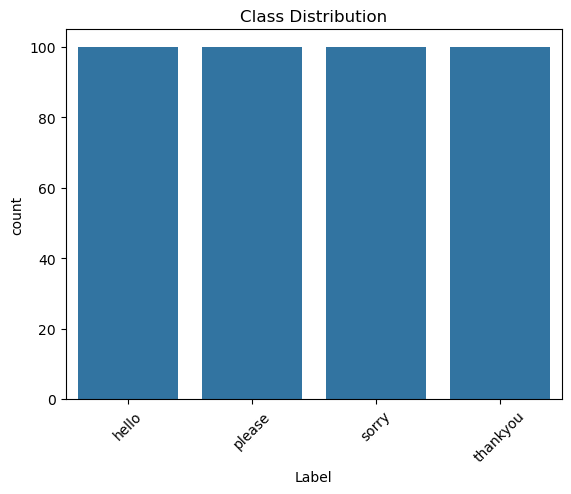

In [4]:
df = pd.DataFrame({'Label': y})
sns.countplot(data=df, x='Label')
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

# Encode labels

In [5]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)


# Split Dataset

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_cat, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_cat)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=VAL_SIZE/(1 - TEST_SIZE),
    random_state=RANDOM_STATE,
    stratify=y_train_val
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 279, Val: 61, Test: 60


# Build model

In [7]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(SEQUENCE_LENGTH, FEATURE_DIM)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\renal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 128)        │        97,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,124 (801.27 KB)

 Trainable params: 205,124 (801.27 KB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [8]:
checkpoint_path = 'artifacts/best_gesture_model.h5'
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3578 - loss: 1.2801

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.3635 - loss: 1.2711 - val_accuracy: 0.7213 - val_loss: 0.6907
Epoch 2/50
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7293 - loss: 0.6837

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7307 - loss: 0.6795 - val_accuracy: 0.7869 - val_loss: 0.3963
Epoch 3/50
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7787 - loss: 0.5585

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7786 - loss: 0.5565 - val_accuracy: 0.8689 - val_loss: 0.3343
Epoch 4/50
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8176 - loss: 0.4141

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8172 - loss: 0.4153 - val_accuracy: 0.9180 - val_loss: 0.2724
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8579 - loss: 0.3423 - val_accuracy: 0.8852 - val_loss: 0.3108
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8529 - loss: 0.3948 - val_accuracy: 0.9180 - val_loss: 0.2963
Epoch 7/50
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8945 - loss: 0.3052

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8954 - loss: 0.3017 - val_accuracy: 0.9344 - val_loss: 0.1757
Epoch 8/50
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8960 - loss: 0.2796

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8994 - loss: 0.2729 - val_accuracy: 0.9508 - val_loss: 0.1581
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9691 - loss: 0.1386 - val_accuracy: 0.9672 - val_loss: 0.1725
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9858 - loss: 0.0660 - val_accuracy: 0.9344 - val_loss: 0.1834
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9821 - loss: 0.0990 - val_accuracy: 0.9344 - val_loss: 0.2027
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9336 - loss: 0.1657 - val_accuracy: 0.9508 - val_loss: 0.1627
Epoch 13/50
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9575 - loss: 0.1267

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9567 - loss: 0.1275 - val_accuracy: 0.9508 - val_loss: 0.1519
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9783 - loss: 0.0817 - val_accuracy: 0.9672 - val_loss: 0.1589
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9749 - loss: 0.0866 - val_accuracy: 0.9508 - val_loss: 0.1637
Epoch 16/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9561 - loss: 0.1216 - val_accuracy: 0.9508 - val_loss: 0.1855
Epoch 17/50
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9462 - loss: 0.1266

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9477 - loss: 0.1229 - val_accuracy: 0.9672 - val_loss: 0.1341
Epoch 18/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9884 - loss: 0.0633 - val_accuracy: 0.9672 - val_loss: 0.1542
Epoch 19/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9944 - loss: 0.0307 - val_accuracy: 0.9672 - val_loss: 0.1567
Epoch 20/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9896 - loss: 0.0426 - val_accuracy: 0.9672 - val_loss: 0.1617
Epoch 21/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9945 - loss: 0.0232 - val_accuracy: 0.9672 - val_loss: 0.1835
Epoch 22/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.0352 - val_accuracy: 0.9672 - val_loss: 0.1694
Epoch 23/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9783 - loss: 0.0376 - val_accuracy: 0.9344 - val_loss: 0.1932
Epoch 24/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9909 - loss: 0.0558 - val_accuracy: 0.9508 - val_l

# Plot training history

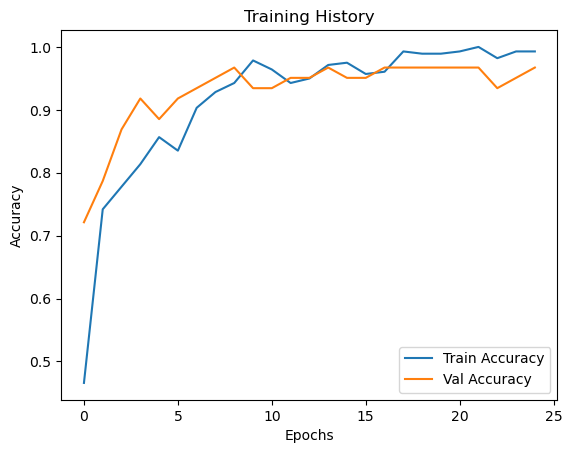

In [9]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training History")
plt.show()


# Evaluate and Analyze Model

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0126
Test Accuracy: 1.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step

Classification Report:
              precision    recall  f1-score   support

       hello       1.00      1.00      1.00        15
      please       1.00      1.00      1.00        15
       sorry       1.00      1.00      1.00        15
    thankyou       1.00      1.00      1.00        15

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



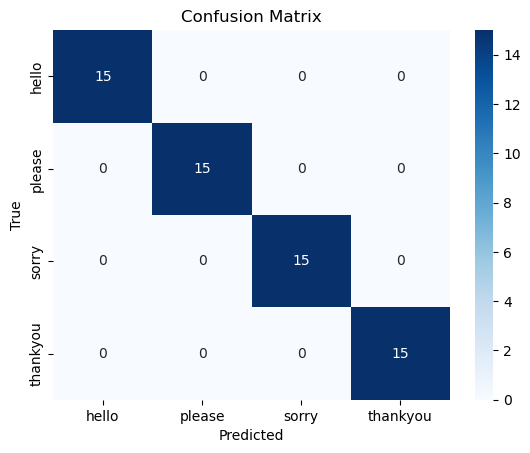

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

y_pred = model.predict(X_test)
y_pred_labels = le.inverse_transform(np.argmax(y_pred, axis=1))
y_true_labels = le.inverse_transform(np.argmax(y_test, axis=1))

print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels))

cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Save Artifacts

In [11]:
with open('artifacts/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Model and label encoder saved.")


Model and label encoder saved.
